In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum, mean as spark_mean, isnull, explode

In [2]:
# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("AnalisisMongo")\
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/Metadata.Transcription")\
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/Metadata.Transcription")\
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1,com.johnsnowlabs.nlp:spark-nlp_2.12:4.4.2")\
    .config("spark.jars.repositories", "https://repos.spark-packages.org/")\
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/06/20 21:30:04 WARN Utils: Your hostname, esquezada resolves to a loopback address: 127.0.1.1; using 172.23.56.33 instead (on interface eth0)
24/06/20 21:30:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
https://repos.spark-packages.org/ added as a remote repository with the name: repo-1
Ivy Default Cache set to: /home/esquezada/.ivy2/cache
The jars for the packages stored in: /home/esquezada/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-66d05f7d-c869-4750-b6ef-3128c8b8eba6;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.4.2 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guava#failureaccess;1.0.1 in central
	found com.google.guava#listenablefuture;9999.0-

In [3]:
# Leer los documentos de MongoDB como un DataFrame de Spark
df = spark.read.format("mongo").load()

df.show()

+--------+--------------------+--------------------+----------+--------------------+---------------+--------------------+--------------------+--------------------+
|Duration|         EndDatetime|              FileId|  FileName|          FolderName|         SizeMb|       StartDatetime|       Transcription|                 _id|
+--------+--------------------+--------------------+----------+--------------------+---------------+--------------------+--------------------+--------------------+
| 2187.72|2024-06-18 21:15:...|a473cf3a-de7f-466...|132379.mp4|Herramientas de V...|4.4110107421875|2024-06-18 21:11:...|[{0, 72334268-6bb...|{66728593d002deaa...|
| 2748.48|2024-06-18 21:04:...|b4a961c2-fa01-420...|141021.mp4|Herramientas de V...|   5.9326171875|2024-06-18 20:58:...|[{0, 1baabad2-915...|{6672830dd002deaa...|
|  3353.2|2024-06-18 21:11:...|3651b63f-9aca-4a9...|167425.mp4|Herramientas de V...|   5.9326171875|2024-06-18 21:05:...|[{0, 3aadc529-e94...|{66728496d002deaa...|
|  3191.4|2024-0

>EDA

In [4]:
# Contar el número de registros
print(f"Total number of records: {df.count()}")

Total number of records: 155


In [5]:
# Mostrar una muestra de los datos
df.select("FileName", "Duration", "SizeMb").show(5)

+----------+--------+---------------+
|  FileName|Duration|         SizeMb|
+----------+--------+---------------+
|132379.mp4| 2187.72|4.4110107421875|
|141021.mp4| 2748.48|   5.9326171875|
|167425.mp4|  3353.2|   5.9326171875|
|135130.mp4|  3191.4|   5.9326171875|
|137933.mp4| 3458.56|   5.9326171875|
+----------+--------+---------------+
only showing top 5 rows



In [6]:
#Agrupar por FolderName (Nombre de la materia) y contar el número de videos
df.groupBy("FolderName").count().show()

+--------------------+-----+
|          FolderName|count|
+--------------------+-----+
|Razonamiento y pl...|   21|
|Trabajo Fin de Má...|    4|
|Análisis e Interp...|   19|
|Gobierno del Dato...|   13|
|Herramientas de V...|   13|
|Técnicas de Intel...|   17|
|Ingeniería para e...|   16|
|Visualización Int...|   16|
|Bases de Datos pa...|   17|
|Sistemas Cognitiv...|   19|
+--------------------+-----+



In [7]:
# Obtener estadísticas descriptivas de las duraciones de los archivos
df.select("Duration").describe().show()

+-------+------------------+
|summary|          Duration|
+-------+------------------+
|  count|               155|
|   mean| 3505.747741935484|
| stddev|1373.6622867402307|
|    min|            257.68|
|    max|           7408.44|
+-------+------------------+



In [4]:
# Análisis de la transcripción
exploded_df = df.select("FileId", "FileName", "FolderName", "Duration", explode("Transcription").alias("Transcription"))
transcription_df = exploded_df.select("FileId", "FileName", "FolderName", "Duration", 
                                      "Transcription.StartTime", 
                                      "Transcription.EndTime", 
                                      "Transcription.Text")

# Mostrar algunas transcripciones
transcription_df.show(5)

+--------------------+----------+--------------------+--------+------------------+------------------+--------------------+
|              FileId|  FileName|          FolderName|Duration|         StartTime|           EndTime|                Text|
+--------------------+----------+--------------------+--------+------------------+------------------+--------------------+
|a473cf3a-de7f-466...|132379.mp4|Herramientas de V...| 2187.72|               0.0|              8.78| Bueno, pues much...|
|a473cf3a-de7f-466...|132379.mp4|Herramientas de V...| 2187.72|              8.78|16.080000000000002| herramientas de ...|
|a473cf3a-de7f-466...|132379.mp4|Herramientas de V...| 2187.72|16.080000000000002|              23.8| Como siempre, cu...|
|a473cf3a-de7f-466...|132379.mp4|Herramientas de V...| 2187.72|              23.8|             29.32| de lo que va a o...|
|a473cf3a-de7f-466...|132379.mp4|Herramientas de V...| 2187.72|             29.32|             34.72| conocimientos. L...|
+---------------

In [7]:
# Eliminar registros vacíos en el campo Text
transcription_df_cleaned = transcription_df.filter(~(isnull("Text") | (col("Text") == "")))
print(transcription_df.count(), transcription_df_cleaned.count())

123187 123187


> Generación de variables calculadas

In [10]:


# Calcular los segundos de cada transcripción
transcription_df_cleaned = transcription_df_cleaned.withColumn("DurationSegment", col("EndTime") - col("StartTime"))

# Calcular el tiempo total de las transcripciones por FileId
transcription_time_df = transcription_df_cleaned.groupBy("FileId").agg(spark_sum("DurationSegment").alias("TotalTranscriptionTime"))

# Unir con el DataFrame original para obtener la duración total del video
silence_df = transcription_time_df.join(df.select("FileId", "FileName", "FolderName","Duration"), on="FileId")

# Calcular el tiempo de silencio
silence_df = silence_df.withColumn("SilenceTime", col("Duration") - col("TotalTranscriptionTime"))

# Mostrar los resultados
silence_df.select("FileId", "FileName", "FolderName", "Duration", "TotalTranscriptionTime", "SilenceTime").show()


+--------------------+----------+--------------------+--------+----------------------+------------------+
|              FileId|  FileName|          FolderName|Duration|TotalTranscriptionTime|       SilenceTime|
+--------------------+----------+--------------------+--------+----------------------+------------------+
|d96d5c7c-b433-412...|148625.mp4|Herramientas de V...| 3552.88|    3324.1600000000017|228.71999999999844|
|c815c28b-a1ce-4ee...| 91696.mp4|Bases de Datos pa...| 1492.56|    1415.1199999999997| 77.44000000000028|
|5df37296-8c11-4a6...|108436.mp4|Ingeniería para e...| 5841.24|     5594.859999999999|246.38000000000102|
|e5527985-4c7a-45c...|110623.mp4|Técnicas de Intel...|  5444.4|               4995.08| 449.3199999999997|
|eb605cc0-fe6b-433...| 92192.mp4|Visualización Int...|  5399.8|    5207.2199999999975|192.58000000000266|
|785e1baa-d01a-4b6...|102739.mp4|Técnicas de Intel...| 2766.28|                2637.8|128.48000000000002|
|4a0a6d51-3e92-4b4...|136696.mp4|Sistemas Cogn

In [11]:
silence_df.write.format("mongo") \
    .mode("overwrite") \
    .option("uri", "mongodb://localhost:27017/Metadata.Silences") \
    .save()

print("DataFrame guardado en MongoDB con éxito.")

DataFrame guardado en MongoDB con éxito.


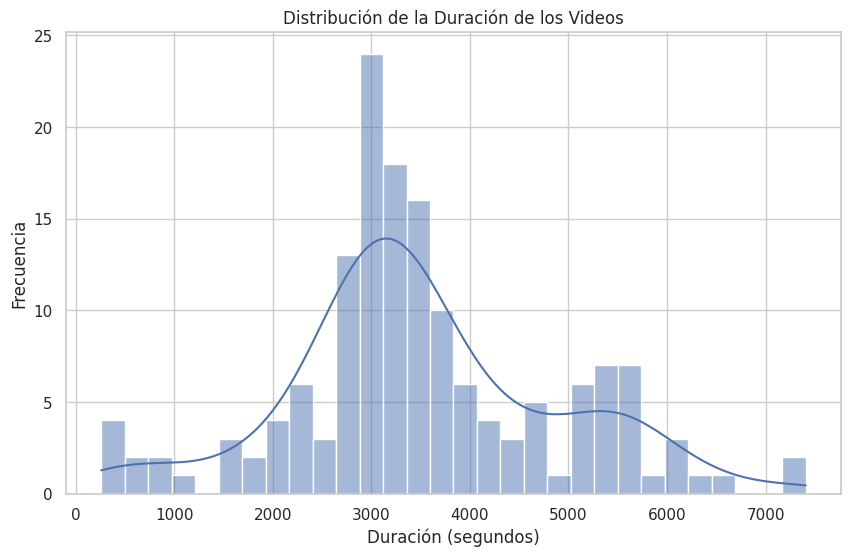

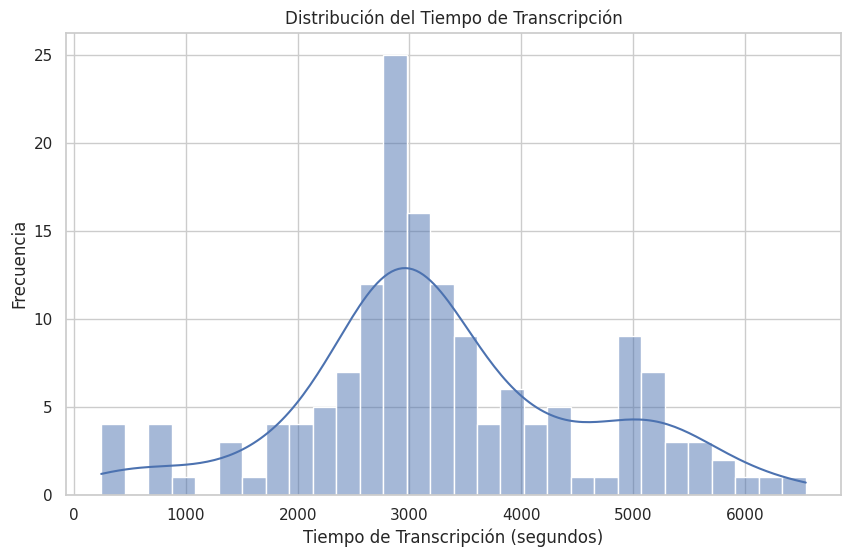

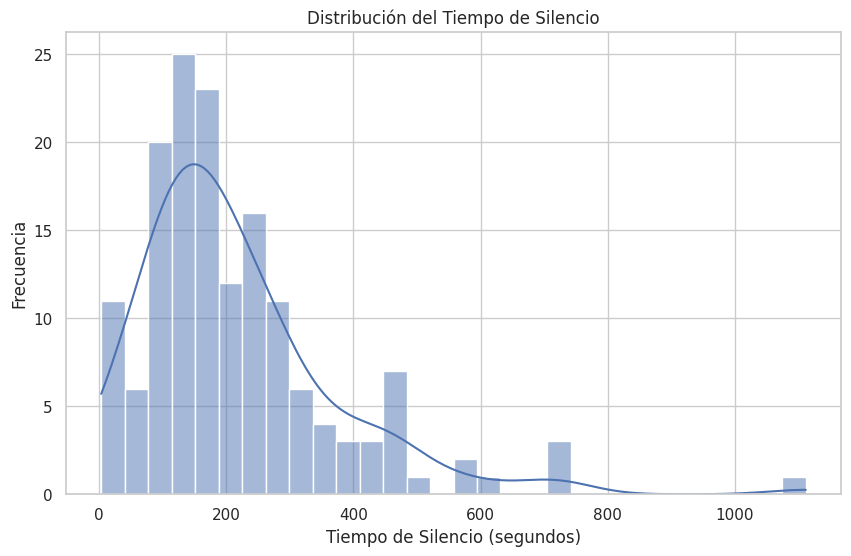

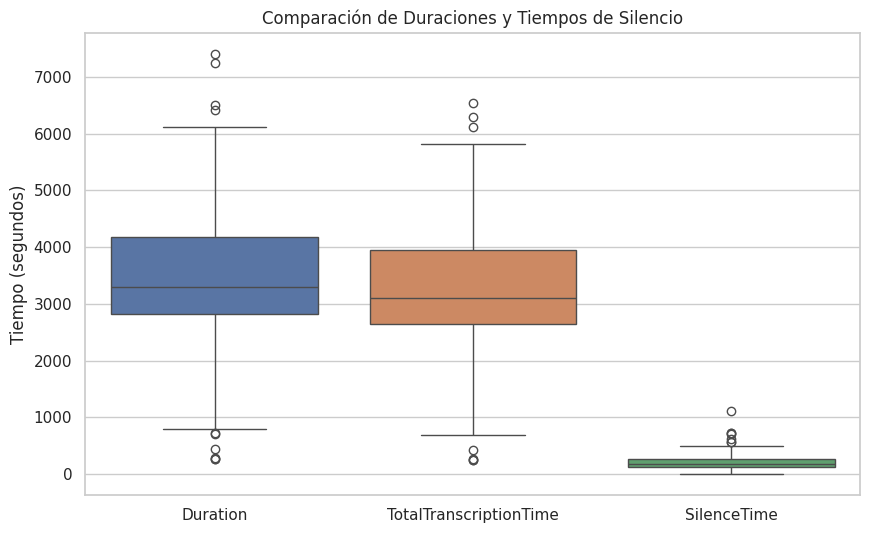

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertir a Pandas DataFrame
silence_pd_df = silence_df.select("FileId", "Duration", "TotalTranscriptionTime", "SilenceTime").toPandas()

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Distribución de la Duración de los Videos
plt.figure(figsize=(10, 6))
sns.histplot(silence_pd_df['Duration'], bins=30, kde=True)
plt.title('Distribución de la Duración de los Videos')
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
plt.show()

# Distribución del Tiempo de Transcripción
plt.figure(figsize=(10, 6))
sns.histplot(silence_pd_df['TotalTranscriptionTime'], bins=30, kde=True)
plt.title('Distribución del Tiempo de Transcripción')
plt.xlabel('Tiempo de Transcripción (segundos)')
plt.ylabel('Frecuencia')
plt.show()

# Distribución del Tiempo de Silencio
plt.figure(figsize=(10, 6))
sns.histplot(silence_pd_df['SilenceTime'], bins=30, kde=True)
plt.title('Distribución del Tiempo de Silencio')
plt.xlabel('Tiempo de Silencio (segundos)')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot para Comparar Duraciones y Tiempos de Silencio
plt.figure(figsize=(10, 6))
sns.boxplot(data=silence_pd_df[['Duration', 'TotalTranscriptionTime', 'SilenceTime']])
plt.title('Comparación de Duraciones y Tiempos de Silencio')
plt.ylabel('Tiempo (segundos)')
plt.show()


In [13]:
# Calcular la media de silencios por FolderName
mean_silence_by_folder = silence_df.groupBy("FolderName").agg(spark_mean("SilenceTime").alias("MeanSilenceTime"))

# Mostrar los resultados
mean_silence_by_folder.show()

+--------------------+------------------+
|          FolderName|   MeanSilenceTime|
+--------------------+------------------+
|Razonamiento y pl...|215.62571428571366|
|Trabajo Fin de Má...|259.98000000000013|
|Análisis e Interp...| 177.7526315789473|
|Gobierno del Dato...|241.38153846153853|
|Herramientas de V...|282.85230769230736|
|Técnicas de Intel...| 261.0670588235292|
|Ingeniería para e...|264.62124999999986|
|Visualización Int...| 128.0899999999997|
|Bases de Datos pa...|285.75294117646956|
|Sistemas Cognitiv...|127.43052631578935|
+--------------------+------------------+



/tmp/ipykernel_687/3701077738.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_silence_pd_df, x="FolderName", y="MeanSilenceTime", palette="viridis")


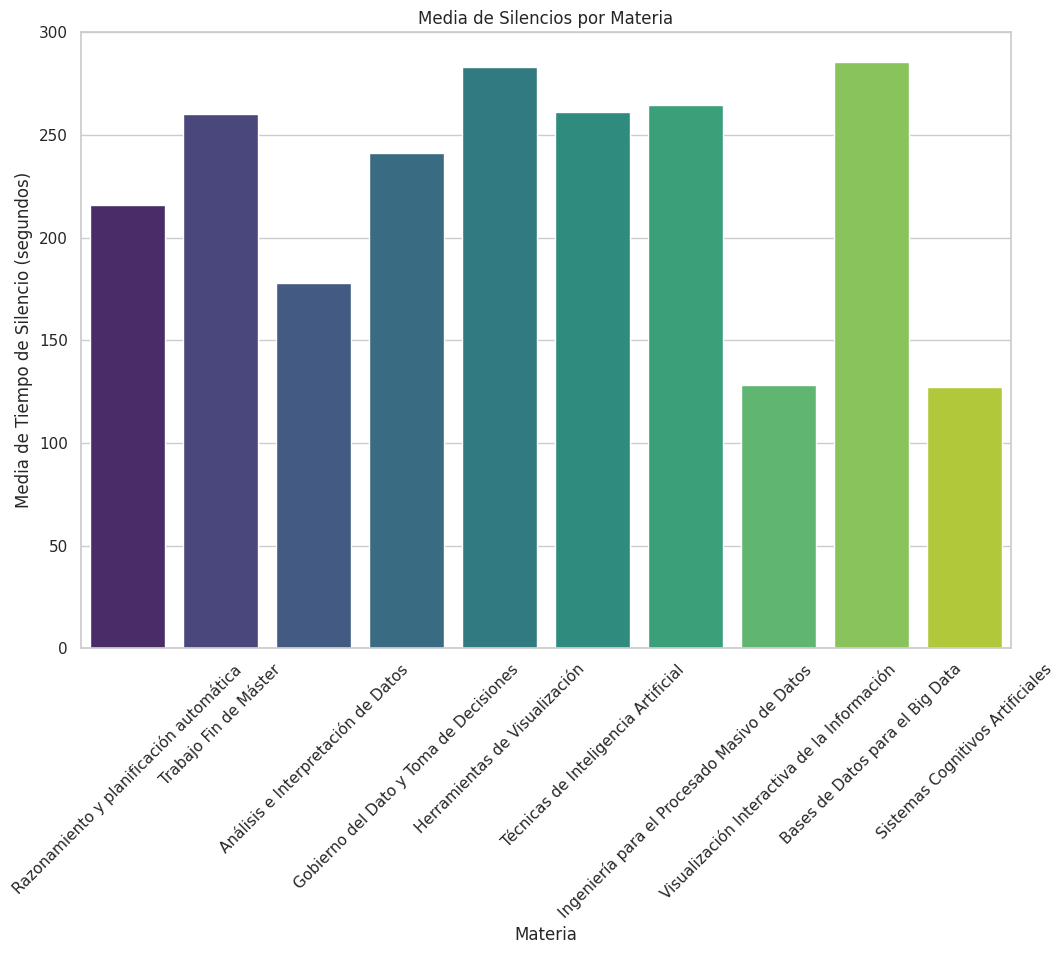

In [14]:
# Convertir a Pandas DataFrame
mean_silence_pd_df = mean_silence_by_folder.toPandas()

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Visualización de la Media de Silencios por FolderName
plt.figure(figsize=(12, 8))
sns.barplot(data=mean_silence_pd_df, x="FolderName", y="MeanSilenceTime", palette="viridis")
plt.title('Media de Silencios por Materia')
plt.xlabel('Materia')
plt.ylabel('Media de Tiempo de Silencio (segundos)')
plt.xticks(rotation=45)
plt.show()


>Bloque para generación de valor con Procesamiento de lenguaje natural

In [5]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, ceil, col, udf, collect_list
from pyspark.sql.types import ArrayType, StringType

num_groups = 50
# Assuming your PySpark DataFrame is named `transcription_df_cleaned` (after cleaning)

# Define the window specification
window_spec = Window.partitionBy("FileId", "FileName", "FolderName").orderBy("StartTime")

# Add row_number and group_number columns
transcription_df = transcription_df.withColumn("row_number", row_number().over(window_spec))
transcription_df = transcription_df.withColumn("group_number", ceil(col("row_number") / num_groups))

# Define a UDF to concatenate text in groups
def concatenate_text(text_list):
    grouped_text = []
    current_group = []
    for text in text_list:
        current_group.append(text)
        if len(current_group) == num_groups:
            grouped_text.append(" ".join(current_group))
            current_group = []
    if current_group:  # Concatenar cualquier texto restante si el último grupo tiene menos de 5 elementos
        grouped_text.append(" ".join(current_group))
    return ' '.join(grouped_text)

concatenate_udf = udf(concatenate_text, StringType())

# Group by and collect text in lists
grouped_df = transcription_df.groupBy("FileId", "FileName", "FolderName", "group_number").agg(collect_list("Text").alias("text_list"))

# Apply the UDF to concatenate text in groups
grouped_df = grouped_df.withColumn("grouped_text", concatenate_udf(col("text_list")))

# Select final columns
final_df = grouped_df.select("FileId", "FileName", "FolderName", "grouped_text")

# Show the first 5 rows
final_df.show(5, truncate=False)

+------------------------------------+----------+-----------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
import yake
from keybert import KeyBERT
from pyspark.sql.functions import collect_list, udf, count
from pyspark.sql.types import ArrayType, StringType

def extract_keywords_keybert(text):
    kw_extractor = yake.KeywordExtractor(top=100)
    candidates = kw_extractor.extract_keywords(text)
    candidates = [candidate[0] for candidate in candidates]

    # Pass candidates to KeyBERT
    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(3, 3), stop_words='english',
                                use_mmr=True, diversity=0.3, candidates=candidates, nr_candidates=100, top_n=30)
    keywords_list = [i[0].strip() for i in keywords]
    return keywords_list

# Definir una UDF para aplicar KeyBERT
extract_keywords_udf = udf(extract_keywords_keybert, ArrayType(StringType()))

result_df = final_df.withColumn("keywords", extract_keywords_udf(col("grouped_text")))

# Explotar las keywords para tener una fila por keyword
exploded_df = result_df.select("FileId", "FileName", "FolderName", explode("keywords").alias("Phrase"))

# Contar la frecuencia de cada keyword por FileName
phrase_counts_df = exploded_df.groupBy("FileId", "FileName", "FolderName", "Phrase").agg(
    count("Phrase").alias("TotalCount")
).orderBy("FileName", "TotalCount", ascending=False)

# Mostrar los resultados
#keyword_counts_df.show()

phrase_counts_df.write.format("mongo") \
    .mode("overwrite") \
    .option("uri", "mongodb://localhost:27017/Metadata.Phrases") \
    .save()

print("DataFrame guardado en MongoDB con éxito.")

/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:1366: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:1366: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:1366: UserWa

DataFrame guardado en MongoDB con éxito.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Tomar las 10 primeras filas (top 10 keywords)
top_10_keywords = phrase_counts_df.limit(10).toPandas()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))  # Ajustar el tamaño según sea necesario
plt.bar(top_10_keywords['keyword'], top_10_keywords['total_count'])

# Etiquetar los ejes y agregar título
plt.xlabel('Keyword')
plt.ylabel('Global Count')
plt.title('Top 10 Keywords')
plt.xticks(rotation=45, ha="right")  # Rotar las etiquetas del eje x para mejor legibilidad

# Mostrar el gráfico
plt.show()


/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:1366: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:1366: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:1366: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:1366: UserWarning: Upper case characters found in vocabula

KeyError: 'keyword'

<Figure size 1200x600 with 0 Axes>

In [8]:
from sentence_transformers import SentenceTransformer
from pyspark.sql.functions import collect_list, udf, count
from pyspark.sql.types import ArrayType, StringType
from keybert import KeyBERT
import spacy
model = SentenceTransformer('all-mpnet-base-v2')  # Modelo ligero de sentence-transformers
kw_model = KeyBERT(model)
nlp = spacy.load("es_core_news_sm")  # Carga el modelo en español


def extract_keywords_keybert(text):
    keywords = kw_model.extract_keywords(
        text, 
        keyphrase_ngram_range=(1, 1),  # Rango de n-gramas (1 para palabras individuales, 2 para bigramas)
        stop_words='english',         # Lista de stopwords en español
        top_n=15                   # Número de palabras clave a extraer
    )
    keywords = [keyword[0] for keyword in keywords]  # Devolver solo las palabras clave
    lemmatized = []
    for keyword in keywords:
        doc = nlp(keyword)
        for token in doc:
            lemmatized.append(token.lemma_)
    lemmatized = list(set(lemmatized))
    return lemmatized

# Definir una UDF para aplicar KeyBERT
extract_keywords_udf = udf(extract_keywords_keybert, ArrayType(StringType()))

result_df = final_df.withColumn("keywords", extract_keywords_udf(col("grouped_text")))

# Explotar las keywords para tener una fila por keyword
exploded_df = result_df.select("FileId", "FileName", "FolderName", explode("keywords").alias("Keyword"))

# Contar la frecuencia de cada keyword por FileName
keyword_counts_df = exploded_df.groupBy("FileId", "FileName", "FolderName", "Keyword").agg(
    count("Keyword").alias("TotalCount")
).orderBy("FileName", "TotalCount", ascending=False)

/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [9]:
keyword_counts_df.show()

ERROR:root:Exception while sending command.                         (0 + 6) / 6]
Traceback (most recent call last):
  File "/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 50842)
Traceback (most recent call last):
  File "/usr/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/h

Py4JError: An error occurred while calling o179.showString

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/esquezada/Tesis/BuscardorVideos_UNIR_TFM/.venv/lib/python3.11/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


In [6]:
from pyspark.sql.functions import collect_list, udf, count
from pyspark.sql.types import ArrayType, StringType
import spacy
nlp = spacy.load("es_core_news_sm")  # Carga el modelo en español


def simple_keyword_extract(text):
    doc = nlp(text)
    keywords = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return list(set(keywords))  # Remove duplicates

extract_keywords_udf = udf(simple_keyword_extract, ArrayType(StringType()))

result_df = final_df.withColumn("keywords", extract_keywords_udf(col("grouped_text")))

# Explotar las keywords para tener una fila por keyword
exploded_df = result_df.select("FileId", "FileName", "FolderName", explode("keywords").alias("Keyword"))

# Contar la frecuencia de cada keyword por FileName
keyword_counts_df = exploded_df.groupBy("FileId", "FileName", "FolderName", "Keyword").agg(
    count("Keyword").alias("TotalCount")
).orderBy("FileName", "TotalCount", ascending=False)

In [7]:
# Mostrar los resultados
keyword_counts_df.write.format("mongo") \
    .mode("overwrite") \
    .option("uri", "mongodb://localhost:27017/Metadata.Keywords") \
    .save()

print("DataFrame guardado en MongoDB con éxito.")

DataFrame guardado en MongoDB con éxito.


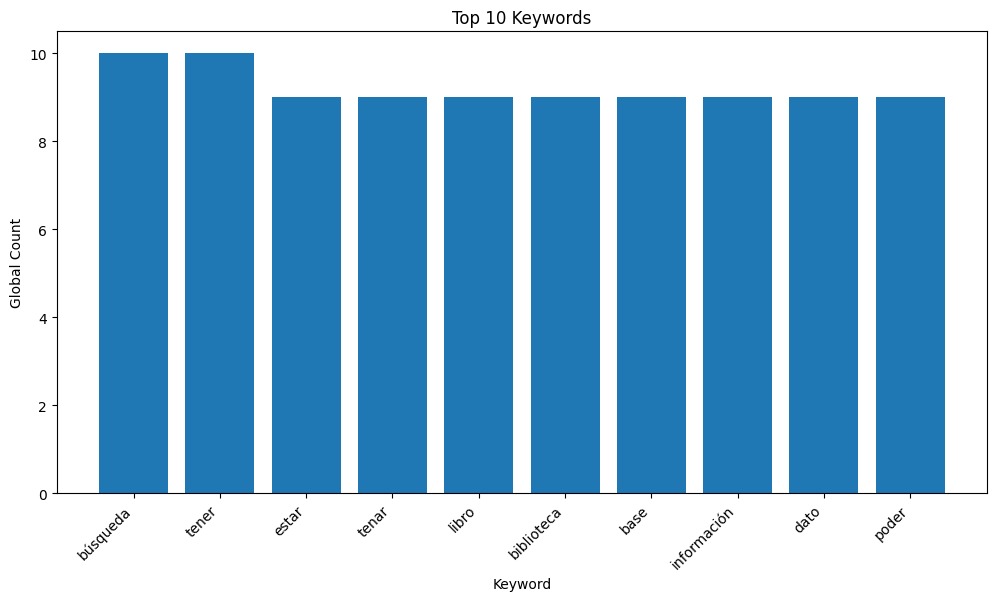

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Tomar las 10 primeras filas (top 10 keywords)
top_10_keywords = keyword_counts_df.limit(10).toPandas()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))  # Ajustar el tamaño según sea necesario
plt.bar(top_10_keywords['Keyword'], top_10_keywords['TotalCount'])

# Etiquetar los ejes y agregar título
plt.xlabel('Keyword')
plt.ylabel('Global Count')
plt.title('Top 10 Keywords')
plt.xticks(rotation=45, ha="right")  # Rotar las etiquetas del eje x para mejor legibilidad

# Mostrar el gráfico
plt.show()


from keybert import KeyBERT

doc = """
Hola, ¿qué tal? Muy buenas tardes a todos y a todas. Bienvenidos a una nueva clase de  la Asignatura de Visualización Interactiva de Información. En la última sesión estuvimos  hablando del tema 4, tratando del tema 4 Psicología aplicada al diseño de visualizaciones. Y nos  quedamos ya en la última parte que se correspondía con cómo pensamos, cómo tomamos decisiones,  cómo interpretamos la información que vemos en cada momento. Vamos a continuar y finalizar  este tema 4, la parte teórica que quedaría y después veremos algún ejemplo práctico  sobre estas cuestiones y sobre cómo se aplica. Bueno, pues como segundo que comparta.  Como decía, estuvimos viendo el tema 4. Empezamos con el tema 4, lo hemos tratado  de forma muy extensa, ya que hemos hablado de percepción visual, hemos hablado de la  memoria y por último estábamos hablando de la racionalidad, de cómo pensamos y tomamos decisiones.  Lo que vimos o de lo que empezamos a hablar fue de que los seres humanos no somos seres 100%  racionales, que tenemos una gran parte de nuestra conducta, nuestro comportamiento se rige, digamos,  por nuestro comportamiento emocional. Explicamos y comentamos cuáles eran los sistemas que utilizamos  para pensar, para tomar decisiones, para comportarnos y para interpretar la información y para dar  sentido a la información que vemos en cada momento. Hablamos del sistema 1, sistema intuitivo y el  sistema racional. Y hablando del sistema intuitivo, ya que decíamos que era el sistema que utilizamos  en la inmensa mayoría de nuestro comportamiento cotidiano, pues decíamos que nos permitía un  comportamiento más eficiente, pero al mismo tiempo era presa de los sesgos cognitivos,  de estos errores sistemáticos del pensamiento. Poníamos un ejemplo de sesgo cognitivo y terminábamos  diciendo que existen muchísimos sesgos cognitivos, muchísimos errores predecibles del pensamiento,  que por tanto, digamos, como son predecibles precisamente las empresas de marketing,  el sector de marketing explota habitualmente para persuadirnos de comprar y de tomar decisiones,  que al final digamos a las empresas que toman esas decisiones de diseño les favorecen.  Nos quedamos en esta parte, he comentado rápidamente por dónde nos quedamos.  Cuando pensamos en visualización de datos, debemos pensar que las visualizaciones de datos  no son simplemente representaciones gráficas. Nosotros cuando representamos información,  estamos comunicando, estamos influyendo y estamos dirigiendo al usuario o al lector desde un punto A  hasta un punto B. Al final podemos decir que las visualizaciones de datos, más que representaciones  simples de datos, son argumentaciones o argumentos basados en datos. Esto quiere decir que toda  visualización está impregnada de una intencionalidad y que por tanto estos argumentos  visuales lo que van a intentar es, basándose en datos, llevar al usuario o lector hacia la  conclusión lógica que estos datos nos sugieren. Aquí tenemos un ejemplo clásico donde vemos el  número de casos de esta enfermedad en los diferentes estados de Estados Unidos y qué  es lo que ocurre a partir de que se introduce la vacuna y vemos cómo van desapareciendo los casos  en todos los estados de Estados Unidos. Como digo, esto no es sólo una representación gráfica,  al final lo que nos está explicando hacia la conclusión que nos lleva es hacia la conclusión  que nos llevan los datos mismos y es la efectividad que tiene precisamente la introducción de esta  vacuna en la erradicación de una enfermedad como esta. Si bien las visualizaciones son  argumentos basados en datos, también existen las falacias basadas en datos. ¿Qué sería una falacia  basada en datos? Una falacia es una argumentación que pareciendo válida no lo es. De hecho,  en concreto podemos hablar de dos grandes grupos de falacias basadas en datos que vamos a mencionar  y vamos a comentar con ejemplos. Por un lado, las falacias visuales. Esto tiene que ver con la forma  en la que se representan los datos, es decir, es la misma forma en la que se representan los datos las  que llevan o inducen al lector hacia una conclusión errónea o contraria a la que los propios datos nos  están dirigiendo. Después están las falacias racional o informacional. En estos casos no es la forma  de representar esos datos sino la elección de qué información se representa y qué información no se  representa. En todos los ejemplos que vamos a ver a continuación, vamos a decir la manipulación,  digamos cuando hay una intencionalidad podríamos hablar de una manipulación, una persuasión,  no está en los datos, es decir, no es que se mienta con los datos. Todos los datos que vamos  a ver representados son correctos, son reales. En todo caso, está en la forma de representar o en          
"""
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=(2, 3), stop_words='english',
                              use_mmr=True, diversity=0.2, top_n=10)
keywords

import yake
from keybert import KeyBERT

# Create candidates
kw_extractor = yake.KeywordExtractor(top=100)
candidates = kw_extractor.extract_keywords(doc)
candidates = [candidate[0] for candidate in candidates]

# Pass candidates to KeyBERT
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=(3, 3), stop_words='english',
                              use_mmr=True, diversity=0.5, candidates=candidates, nr_candidates=100, top_n=10)
keywords_list = [i[0] for i in keywords]
keywords_list

from sentence_transformers import SentenceTransformer
from keybert import KeyBERT
import spacy
model = SentenceTransformer('all-mpnet-base-v2')  # Modelo ligero de sentence-transformers
kw_model = KeyBERT(model)
nlp = spacy.load("es_core_news_sm")  # Carga el modelo en español

def extract_keywords(text, top_n=15):
    keywords = kw_model.extract_keywords(
        text, 
        keyphrase_ngram_range=(1, 1),  # Rango de n-gramas (1 para palabras individuales, 2 para bigramas)
        stop_words='english',         # Lista de stopwords en español
        top_n=top_n                   # Número de palabras clave a extraer
    )
    keywords = [keyword[0] for keyword in keywords]  # Devolver solo las palabras clave
    lemmatized = []
    for keyword in keywords:
        doc = nlp(keyword)
        for token in doc:
            lemmatized.append(token.lemma_)
    lemmatized = list(set(lemmatized))
    return lemmatized

paragraph = "Hola, ¿qué tal? Muy buenas tardes a todos y a todas. Bienvenidos a una nueva clase de  la Asignatura de Visualización Interactiva de Información. En la última sesión estuvimos  hablando del tema 4, tratando del tema 4 Psicología aplicada al diseño de visualizaciones. Y nos  quedamos ya en la última parte que se correspondía con cómo pensamos, cómo tomamos decisiones,  cómo interpretamos la información que vemos en cada momento. Vamos a continuar y finalizar  este tema 4, la parte teórica que quedaría y después veremos algún ejemplo práctico  sobre estas cuestiones y sobre cómo se aplica. Bueno, pues como segundo que comparta.  Como decía, estuvimos viendo el tema 4. Empezamos con el tema 4, lo hemos tratado  de forma muy extensa, ya que hemos hablado de percepción visual, hemos hablado de la  memoria y por último estábamos hablando de la racionalidad, de cómo pensamos y tomamos decisiones.  Lo que vimos o de lo que empezamos a hablar fue de que los seres humanos no somos seres 100%  racionales, que tenemos una gran parte de nuestra conducta, nuestro comportamiento se rige, digamos,  por nuestro comportamiento emocional. Explicamos y comentamos cuáles eran los sistemas que utilizamos  para pensar, para tomar decisiones, para comportarnos y para interpretar la información y para dar  sentido a la información que vemos en cada momento. Hablamos del sistema 1, sistema intuitivo y el  sistema racional. Y hablando del sistema intuitivo, ya que decíamos que era el sistema que utilizamos  en la inmensa mayoría de nuestro comportamiento cotidiano, pues decíamos que nos permitía un  comportamiento más eficiente, pero al mismo tiempo era presa de los sesgos cognitivos,  de estos errores sistemáticos del pensamiento. Poníamos un ejemplo de sesgo cognitivo y terminábamos  diciendo que existen muchísimos sesgos cognitivos, muchísimos errores predecibles del pensamiento,  que por tanto, digamos, como son predecibles precisamente las empresas de marketing,  el sector de marketing explota habitualmente para persuadirnos de comprar y de tomar decisiones,  que al final digamos a las empresas que toman esas decisiones de diseño les favorecen.  Nos quedamos en esta parte, he comentado rápidamente por dónde nos quedamos.  Cuando pensamos en visualización de datos, debemos pensar que las visualizaciones de datos  no son simplemente representaciones gráficas. Nosotros cuando representamos información,  estamos comunicando, estamos influyendo y estamos dirigiendo al usuario o al lector desde un punto A  hasta un punto B. Al final podemos decir que las visualizaciones de datos, más que representaciones  simples de datos, son argumentaciones o argumentos basados en datos. Esto quiere decir que toda  visualización está impregnada de una intencionalidad y que por tanto estos argumentos  visuales lo que van a intentar es, basándose en datos, llevar al usuario o lector hacia la  conclusión lógica que estos datos nos sugieren. Aquí tenemos un ejemplo clásico donde vemos el  número de casos de esta enfermedad en los diferentes estados de Estados Unidos y qué  es lo que ocurre a partir de que se introduce la vacuna y vemos cómo van desapareciendo los casos  en todos los estados de Estados Unidos. Como digo, esto no es sólo una representación gráfica,  al final lo que nos está explicando hacia la conclusión que nos lleva es hacia la conclusión  que nos llevan los datos mismos y es la efectividad que tiene precisamente la introducción de esta  vacuna en la erradicación de una enfermedad como esta. Si bien las visualizaciones son  argumentos basados en datos, también existen las falacias basadas en datos. ¿Qué sería una falacia  basada en datos? Una falacia es una argumentación que pareciendo válida no lo es. De hecho,  en concreto podemos hablar de dos grandes grupos de falacias basadas en datos que vamos a mencionar  y vamos a comentar con ejemplos. Por un lado, las falacias visuales. Esto tiene que ver con la forma  en la que se representan los datos, es decir, es la misma forma en la que se representan los datos las  que llevan o inducen al lector hacia una conclusión errónea o contraria a la que los propios datos nos  están dirigiendo. Después están las falacias racional o informacional. En estos casos no es la forma  de representar esos datos sino la elección de qué información se representa y qué información no se  representa. En todos los ejemplos que vamos a ver a continuación, vamos a decir la manipulación,  digamos cuando hay una intencionalidad podríamos hablar de una manipulación, una persuasión,  no está en los datos, es decir, no es que se mienta con los datos. Todos los datos que vamos  a ver representados son correctos, son reales. En todo caso, está en la forma de representar o en"
keywords = extract_keywords(paragraph)
print(keywords)  # Output: ['ejemplo', 'párrafo', 'extraer', 'palabras clave', 'términos']


# Detener la sesión de Spark
spark.stop()

In [10]:
import pymongo

# Conexión al servidor MongoDB (reemplaza con tus datos)
client = pymongo.MongoClient("mongodb://localhost:27017/")

# Nombre de la base de datos y colección
db_name = "Metadata"
collection_name = "Transcription"

# Obtener la base de datos y colección
db = client[db_name]
collection = db[collection_name]

# Realizar la consulta (obtiene todos los documentos)
cursor = collection.find()

data = []
# Iterar sobre los resultados e imprimirlos
for documento in cursor:
    data.append(documento)

len(data), data[0]

(155,
 {'_id': ObjectId('66728593d002deaab01dd4b3'),
  'FileId': 'a473cf3a-de7f-466f-ba5a-6b2fe51c31b4',
  'FileName': '132379.mp4',
  'FolderName': 'Herramientas de Visualización',
  'Duration': 2187.72,
  'StartDatetime': datetime.datetime(2024, 6, 19, 2, 11, 31, 753000),
  'EndDatetime': datetime.datetime(2024, 6, 19, 2, 15, 31, 93000),
  'SizeMb': 4.4110107421875,
  'Transcription': [{'Id': 0,
    'TranscriptId': '72334268-6bbd-4c43-aeed-e00dc87286b1',
    'StartTime': 0.0,
    'EndTime': 8.78,
    'Text': ' Bueno, pues muchísimas gracias por asistir a esta primera sesión de la asignatura de'},
   {'Id': 1,
    'TranscriptId': '2ae0bdeb-b500-4950-a2f9-f4abc62a7e5a',
    'StartTime': 8.78,
    'EndTime': 16.080000000000002,
    'Text': ' herramientas de visualización del Master de Visualización, perdón, el Master de Visual Analytics.'},
   {'Id': 2,
    'TranscriptId': 'ba5c48e8-72dd-4177-aa11-230b77f10571',
    'StartTime': 16.080000000000002,
    'EndTime': 23.8,
    'Text': ' Com

In [11]:
import pandas as pd
from functions.chroma_utils import *  # Asegúrate de que la importación sea correcta
import multiprocessing

# Nombre de la base de datos y colección
collection_chroma = init_chroma('Transcription')

def process_transcription(i):
    """Procesa una transcripción individualmente."""
    try:
        list_transcriptions = i['Transcription']
        df_transcriptions = pd.DataFrame(list_transcriptions)
        list_ids = df_transcriptions['TranscriptId'].tolist()
        list_text = df_transcriptions['Text'].tolist()
        df_metadata = df_transcriptions.drop(["Text", "TranscriptId"], axis=1)
        df_metadata['FileId'] = i['FileId']
        df_metadata['FileName'] = i['FileName']
        df_metadata['FolderName'] = i['FolderName']
        dict_metadata = df_metadata.to_dict(orient='records')
        filter = {
            "$and": [
                {"FolderName": i['FolderName']},
                {"FileName": i['FileName']}
            ]
        }
        save_data_chroma(collection_chroma, list_ids, list_text, dict_metadata)
        print(f"Transcription from {i['FileName']} processed.")
    except Exception as e:
        print(f"Error processing {i['FileName']}: {e}")

# Procesar el primer registro
if data:  # Verificar que 'data' no esté vacío
    process_transcription(data[0])

# Paralelizar el resto en lotes de 5
def process_batch(batch):
    for item in batch:
        process_transcription(item)

if __name__ == '__main__':
    if len(data) > 1:  # Verificar si hay más de un registro para paralelizar
        pool = multiprocessing.Pool(processes=5)
        for i in range(1, len(data), 5):
            batch = data[i:i+5]
            pool.apply_async(process_batch, args=(batch,))

        pool.close()
        pool.join()

Total de elementos en la colección: 0
Transcription from 132379.mp4 processed.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Transcription from 165212.mp4 processed.
Transcription from 150869.mp4 processed.
Transcription from 152993.mp4 processed.
Transcription from 141021.mp4 processed.
Transcription from 130988.mp4 processed.
Transcription from 157707.mp4 processed.
Transcription from 156432.mp4 processed.
Transcription from 163935.mp4 processed.
Transcription from 144149.mp4 processed.
Transcription from 134523.mp4 processed.
Transcription from 145411.mp4 processed.
Transcription from 130986.mp4 processed.
Transcription from 150872.mp4 processed.
Transcription from 145434.mp4 processed.
Transcription from 167425.mp4 processed.
Transcription from 136696.mp4 processed.
Transcription from 168376.mp4 processed.
Transcription from 153570.mp4 processed.
Transcription from 135130.mp4 processed.
Transcription from 160314.mp4 processed.
Transcription from 162374.mp4 processed.
Transcription from 146845.mp4 processed.
Transcription from 148625.mp4 processed.
Transcription from 165194.mp4 processed.
Transcription fr